 ![CellphoneDB Logo](https://www.cellphonedb.org/images/cellphonedb_logo_33.png) CellphoneDB is a publicly available repository of curated receptors, ligands and their interactions.

# Case Example 3. Topmost specific interaction during trophoblast invasion.

This case study combines:
- CellphoneDB method 2 
- Microenvrionments
- Scoring prioritisation

to explore cell-cell interactions between the fetal trophoblast and the maternal vessels. See Arutyunyan et al Nature 2023 “eEVT interactions with spiral arteries” section for more details. 

**Biological background.** Fetal trophoblast cells invade the maternal endometrium to remodelate maternal vessels. Here we use single cell transcriptomics analysis to extract and explore the ussage of L/R between the fetal extravillius trophoblast (EVTs) and the maternal perivascular cells (PV). We will use the micronevironemts files to CellphoneDB that we are only interested in interactions between EVTs and PVs, and do not report interaction between other cells.

**Research question.** __What are the cell-cell interactions that are OVEREXPRESSED between the fetal extravillius trophoblast (EVTs) and the maternal perivascular cells (PV)?__
        NOTE there will be interactions constant in all cells but we want to extract the overexpressed with method 2. We will also use the scoring approach to score for L/R specific to a cell type to further prioritise the topmosrelevant interactions. 

This notebook assumes that you either know how two **download CellphoneDB database or to create your own database**. If this is not the case, please check `T0_BuildDBfromFiles.ipynb` or `T0_BuildDBfromRelease.ipynb`. 

#### Check python version

In [1]:
import pandas as pd
import sys
import os

pd.set_option('display.max_columns', 100)

Checking that environment contains a Python >= 3.8 as required by CellphoneDB.

In [2]:
print(sys.version)

3.8.19 | packaged by conda-forge | (default, Mar 20 2024, 12:47:35) 
[GCC 12.3.0]


___
## Input files


Here we aim to retrieve cell-cell interactions involving genes upregulated by any germ or somatic cell state along their differentiation trajectory, with CellPhoneDB method 3. Beside the mandatory dataset's counts and meta files (described [here](https://cellphonedb.readthedocs.io/en/latest/RESULTS-DOCUMENTATION.html#input-files) ), we will provide the following, which configuration is tailored towards our biological question.


- **DEGs file** (mandatory for CellphoneDB method 3), which contains the genes overexpressed by any cell state in any of the two differentiation trajectories (i.e. the germ trajectory and the somatic trajectory). DEGs were calculated using a one-sided Wilcoxon Rank Sum test implemented in the FindAllMarkers function with Seurat v.3.2.2 in a “one versus rest-of-the-lineage” fashion.
>Critical step.
To capture subtle expression differences along each lineage trajectory (the somatic and the germinal), we need to compare each cell state against the other cell states of the same lineage-trajectory in a “one versus rest-of-the-lineage” fashion (i.e. hierarchical differential expression analysis). 
Why “one versus rest-of-the-lineage” and not “one versus all-the-rest”? Because “one versus all-the-rest” does not distinguish cell state-specific from lineage-specific upregulated genes - Here we want to specifically target ligands/receptors upregulated by a specific cell state along their differentiation trajectory, thus our reference should be the cells in the differentiation trajectory (”rest-of-the-lineage”) and not the cells from other lineages (“all-the-rest” including all immune, endothelial, somatic and germ cells together).
- **Microenvironments file.** Because two cells can only interact paracrinally if they colocalise in space and time, we will inform CellphoneDB about the cellular composition of each of the three ovarian microenvironments. CellphoneDB will use this information to restrict the analysis to those cell types that co-localise in each microenvironment (i.e. discard interactions between cells that never co-localise). These spatial niches were identified via spatial transcriptomics analysis where Visium Spatial transcriptomics spots were deconvoluted into single cell type densities using cell2location. 


In [3]:
# Our base directory for the analysis
os.chdir('/home/jovyan/cellphonedb_v500_NatProtocol/CaseExample3_specificityScoring/')

# Path to our input files
cpdb_file_path = '/home/jovyan/cellphonedb_v500_NatProtocol/v5.0.0/cellphonedb.zip'
meta_file_path = '/home/jovyan/cellphonedb_v500_NatProtocol/CaseExample3_specificityScoring/input/metadata.tsv'
counts_file_path = '/home/jovyan/cellphonedb_v500_NatProtocol/CaseExample3_specificityScoring/input/normalised_log_counts.h5ad'
microenvs_file_path = '/home/jovyan/cellphonedb_v500_NatProtocol/CaseExample3_specificityScoring/input/microenvironment.tsv'
out_path = 'results/'



<span style="color:green">**1)**</span> The **metadata** file is compossed of two columns:
- **barcode_sample**: this column indicates the barcode of each cell in the experiment.
- **cell_type**: this column denotes the cell label assigned.

In [4]:
metadata = pd.read_csv(meta_file_path, sep = '\t')
metadata.head(3)

,barcode_sample,cell_type
0,AGCGATTAGTCTAACC-1_Pla_HDBR10917733,B_cells
1,ATCCGTGAGGCTAGAA-1_Pla_Camb10714918,B_cells
2,AGTAACCCATTAAAGG-1_Pla_HDBR10917733,B_cells


<span style="color:green">**2)**</span>  The **counts** files is a h5ad object from scanpy. The dimensions and order of this object must coincide with the dimensions of the metadata file, i.e. must have the same number of cells in both files.

In [5]:
import anndata

adata = anndata.read_h5ad(counts_file_path)
adata.shape

(3312, 30800)

Check barcodes in metadata and counts are the same.

In [6]:
list(adata.obs.index).sort() == list(metadata['cell_type']) \
    .sort()

True

<span style="color:green">**3)**</span> **Micronevironments** defines the cell types that belong to a a given microenvironment. CellphoneDB will only calculate interactions between cells that belong to a given microenvironment. In this file we are defining just one microenvionment.

In [7]:
microenv = pd.read_csv(microenvs_file_path,
                       sep = '\t')
microenv.head(3)

,cell_type,microenvironment
0,PV MMP11,Env1
1,PV MYH11,Env1
2,PV STEAP4,Env1


In [8]:
set(microenv.cell_type)

{'EVT_1',
 'EVT_2',
 'GC',
 'PV MMP11',
 'PV MYH11',
 'PV STEAP4',
 'VCT_CCC',
 'eEVT',
 'iEVT'}

Here we are interested in only one microenvironments that is the cells arround the vessels (the perivascular cells - PVs).

In [9]:
microenv.groupby('microenvironment')['cell_type'].apply(lambda x : list(x.value_counts().index))

microenvironment
Env1    [PV MMP11, PV MYH11, PV STEAP4, EVT_1, EVT_2, ...
Name: cell_type, dtype: object

____
## Run CellphoneDB with method 2
The output of this method will be saved in `output_path` and also assigned to the predefined variables.

In [10]:
from cellphonedb.src.core.methods import cpdb_statistical_analysis_method

cpdb_results = cpdb_statistical_analysis_method.call(
    cpdb_file_path = cpdb_file_path,                            # mandatory: CellphoneDB database zip file.
    meta_file_path = meta_file_path,                            # mandatory: tsv file defining barcodes to cell label.
    counts_file_path = counts_file_path,                        # mandatory: normalized count matrix - a path to the counts file, or an in-memory AnnData object
    counts_data = 'hgnc_symbol',                                # defines the gene annotation in counts matrix.
    microenvs_file_path = microenvs_file_path,                  # optional (default: None): defines cells per microenvironment.
    score_interactions = True,                                  # optional: whether to score interactions or not. 
    threshold = 0.1,                                            # defines the min % of cells expressing a gene for this to be employed in the analysis.
    result_precision = 3,                                       # Sets the rounding for the mean values in significan_means.
    separator = '|',                                            # Sets the string to employ to separate cells in the results dataframes "cellA|CellB".
    debug = False,                                              # Saves all intermediate tables emplyed during the analysis in pkl format.
    output_path = out_path,                                     # Path to save results
    output_suffix = None,                                       # Replaces the timestamp in the output files by a user defined string in the  (default: None)
    threads = 25
    )

Reading user files...
The following user files were loaded successfully:
/home/jovyan/cellphonedb_v500_NatProtocol/CaseExample3_specificityScoring/input/normalised_log_counts.h5ad
/home/jovyan/cellphonedb_v500_NatProtocol/CaseExample3_specificityScoring/input/metadata.tsv
/home/jovyan/cellphonedb_v500_NatProtocol/CaseExample3_specificityScoring/input/microenvironment.tsv
[ ][CORE][25/06/24-10:08:15][INFO] [Cluster Statistical Analysis] Threshold:0.1 Iterations:1000 Debug-seed:-1 Threads:25 Precision:3
[ ][CORE][25/06/24-10:08:16][INFO] Running Real Analysis
[ ][CORE][25/06/24-10:08:16][INFO] Limiting cluster combinations using microenvironments
[ ][CORE][25/06/24-10:08:16][INFO] Running Statistical Analysis


100%|██████████| 1000/1000 [00:21<00:00, 45.62it/s]


[ ][CORE][25/06/24-10:08:38][INFO] Building Pvalues result
[ ][CORE][25/06/24-10:08:39][INFO] Building results
[ ][CORE][25/06/24-10:08:39][INFO] Scoring interactions: Filtering genes per cell type..


100%|██████████| 42/42 [00:00<00:00, 218.39it/s]

[ ][CORE][25/06/24-10:08:39][INFO] Scoring interactions: Calculating mean expression of each gene per group/cell type..



100%|██████████| 42/42 [00:00<00:00, 643.19it/s]


[ ][CORE][25/06/24-10:08:40][INFO] Scoring interactions: Calculating scores for all interactions and cell types..


100%|██████████| 81/81 [00:05<00:00, 16.07it/s]


Saved deconvoluted to results/statistical_analysis_deconvoluted_06_25_2024_100846.txt
Saved deconvoluted_percents to results/statistical_analysis_deconvoluted_percents_06_25_2024_100846.txt
Saved means to results/statistical_analysis_means_06_25_2024_100846.txt
Saved pvalues to results/statistical_analysis_pvalues_06_25_2024_100846.txt
Saved significant_means to results/statistical_analysis_significant_means_06_25_2024_100846.txt
Saved interaction_scores to results/statistical_analysis_interaction_scores_06_25_2024_100846.txt


____
## Results & Outputs

Results are save as files and as a dictionary in the `cpdb_results` variable.

These are the different tables generated. For a full explanation of the outputs, check the documentation [here](https://cellphonedb.readthedocs.io/en/latest/RESULTS-DOCUMENTATION.html#output-files).

In [11]:
list(cpdb_results.keys())

['deconvoluted',
 'deconvoluted_percents',
 'means',
 'pvalues',
 'significant_means',
 'CellSign_active_interactions',
 'CellSign_active_interactions_deconvoluted',
 'interaction_scores']

In [12]:
cpdb_results['interaction_scores'].head()

,id_cp_interaction,interacting_pair,partner_a,partner_b,gene_a,gene_b,secreted,receptor_a,receptor_b,annotation_strategy,is_integrin,directionality,classification,PV MMP11|PV MMP11,PV MMP11|PV MYH11,PV MMP11|PV STEAP4,PV MMP11|EVT_1,PV MMP11|EVT_2,PV MMP11|iEVT,PV MMP11|VCT_CCC,PV MMP11|GC,PV MMP11|eEVT,PV MYH11|PV MMP11,PV MYH11|PV MYH11,PV MYH11|PV STEAP4,PV MYH11|EVT_1,PV MYH11|EVT_2,PV MYH11|iEVT,PV MYH11|VCT_CCC,PV MYH11|GC,PV MYH11|eEVT,PV STEAP4|PV MMP11,PV STEAP4|PV MYH11,PV STEAP4|PV STEAP4,PV STEAP4|EVT_1,PV STEAP4|EVT_2,PV STEAP4|iEVT,PV STEAP4|VCT_CCC,PV STEAP4|GC,PV STEAP4|eEVT,EVT_1|PV MMP11,EVT_1|PV MYH11,EVT_1|PV STEAP4,EVT_1|EVT_1,EVT_1|EVT_2,EVT_1|iEVT,EVT_1|VCT_CCC,EVT_1|GC,EVT_1|eEVT,EVT_2|PV MMP11,EVT_2|PV MYH11,EVT_2|PV STEAP4,EVT_2|EVT_1,EVT_2|EVT_2,EVT_2|iEVT,EVT_2|VCT_CCC,EVT_2|GC,EVT_2|eEVT,iEVT|PV MMP11,iEVT|PV MYH11,iEVT|PV STEAP4,iEVT|EVT_1,iEVT|EVT_2,iEVT|iEVT,iEVT|VCT_CCC,iEVT|GC,iEVT|eEVT,VCT_CCC|PV MMP11,VCT_CCC|PV MYH11,VCT_CCC|PV STEAP4,VCT_CCC|EVT_1,VCT_CCC|EVT_2,VCT_CCC|iEVT,VCT_CCC|VCT_CCC,VCT_CCC|GC,VCT_CCC|eEVT,GC|PV MMP11,GC|PV MYH11,GC|PV STEAP4,GC|EVT_1,GC|EVT_2,GC|iEVT,GC|VCT_CCC,GC|GC,GC|eEVT,eEVT|PV MMP11,eEVT|PV MYH11,eEVT|PV STEAP4,eEVT|EVT_1,eEVT|EVT_2,eEVT|iEVT,eEVT|VCT_CCC,eEVT|GC,eEVT|eEVT
0,CPI-SC0A2DB962D,CDH1_integrin_a2b1_complex,simple:P12830,complex:integrin_a2b1_complex,CDH1,NaN,False,False,False,curated,True,Adhesion-Adhesion,Adhesion by Cadherin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.346,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.843,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.095,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41.533,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74.911,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41.35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,51.391
1,CPI-SC0B5CEA47D,COL10A1_integrin_a2b1_complex,simple:Q03692,complex:integrin_a2b1_complex,COL10A1,NaN,True,False,False,curated,True,Adhesion-Adhesion,Adhesion by Collagen/Integrin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000
2,CPI-SC0C8B7BCBB,COL11A1_integrin_a2b1_complex,simple:P12107,complex:integrin_a2b1_complex,COL11A1,NaN,True,False,False,curated,True,Adhesion-Adhesion,Adhesion by Collagen/Integrin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.588,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000
3,CPI-SC0D3C12C3F,COL11A2_integrin_a2b1_complex,simple:P13942,complex:integrin_a2b1_complex,COL11A2,NaN,True,False,False,curated,True,Adhesion-Adhesion,Adhesion by Collagen/Integrin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000
4,CPI-SC0B86B7CED,COL12A1_integrin_a2b1_complex,simple:Q99715,complex:integrin_a2b1_complex,COL12A1,NaN,True,False,False,curated,True,Adhesion-Adhesion,Adhesion by Collagen/Integrin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.37,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43.348,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000


In [13]:
cpdb_results['significant_means'].classification.value_counts()

classification
Signaling by Glutamate                 350
Signaling by WNT                       335
Adhesion by Collagen/Integrin          171
Signaling by GABA                      168
Signaling by WNT inhibition            100
                                      ... 
Signaling by Melatonin                   1
Signaling by Insulin-like precursor      1
Signaling by Pro-neuregulin              1
Signaling by Serotonin/Dopamine          1
Signaling by Prolactin                   1
Name: count, Length: 157, dtype: int64

#### Explore CellphoneDB outputs

This function allows to filter CellphoneDB results by specifying: cell types pairs, genes or specific interactions.

In **this example** we are going to filter interactions within the cells around the vessels involving the "Signaling by Netrin" pathway.

In [14]:
from cellphonedb.utils import search_utils

search_results = search_utils.search_analysis_results(
    query_cell_types_1 = ['PV MMP11', 'PV MYH11', 'PV STEAP4'],  # List of cells 1, will be paired to cells 2 (list or 'All').
    query_cell_types_2 = ['EVT_1', 'EVT_2', 'GC',  'VCT_CCC', 'eEVT', 'iEVT'],     # List of cells 2, will be paired to cells 1 (list or 'All').
#     query_genes = ['NTRK2'],                                       # filter interactions based on the genes participating (list).
#     query_interactions = [''],                            # filter intereactions based on their name (list).
    significant_means = cpdb_results['significant_means'],          # significant_means file generated by CellphoneDB.
    deconvoluted = cpdb_results['deconvoluted'],                    # devonvoluted file generated by CellphoneDB.
    separator = '|',                                                # separator (default: |) employed to split cells (cellA|cellB).
    long_format = True,                                             # converts the output into a wide table, removing non-significant interactions
    query_classifications = ['Signaling by Netrin']
)

search_results.head(20)

,interacting_pair,partner_a,partner_b,gene_a,gene_b,directionality,classification,interacting_cells,significant_mean
3,NTN4_UNC5D,simple:Q9HB63,simple:Q6UXZ4,NTN4,UNC5D,Ligand-Receptor,Signaling by Netrin,PV MYH11|eEVT,0.114
6,NTN4_NTRK2,simple:Q9HB63,simple:Q16620,NTN4,NTRK2,Ligand-Receptor,Signaling by Netrin,EVT_1|PV MYH11,0.175
7,NTN4_UNC5D,simple:Q9HB63,simple:Q6UXZ4,NTN4,UNC5D,Ligand-Receptor,Signaling by Netrin,EVT_1|PV MYH11,0.054
10,NTN4_NTRK2,simple:Q9HB63,simple:Q16620,NTN4,NTRK2,Ligand-Receptor,Signaling by Netrin,EVT_2|PV MYH11,0.192
11,NTN4_UNC5D,simple:Q9HB63,simple:Q6UXZ4,NTN4,UNC5D,Ligand-Receptor,Signaling by Netrin,EVT_2|PV MYH11,0.071
12,NTN1_UNC5C,simple:O95631,simple:O95185,NTN1,UNC5C,Ligand-Receptor,Signaling by Netrin,EVT_2|PV STEAP4,0.179
17,NTN4_UNC5B,simple:Q9HB63,simple:Q8IZJ1,NTN4,UNC5B,Ligand-Receptor,Signaling by Netrin,iEVT|PV MYH11,0.212
18,NTN4_NTRK2,simple:Q9HB63,simple:Q16620,NTN4,NTRK2,Ligand-Receptor,Signaling by Netrin,iEVT|PV MYH11,0.332
19,NTN4_UNC5D,simple:Q9HB63,simple:Q6UXZ4,NTN4,UNC5D,Ligand-Receptor,Signaling by Netrin,iEVT|PV MYH11,0.212
21,NTN4_UNC5B,simple:Q9HB63,simple:Q8IZJ1,NTN4,UNC5B,Ligand-Receptor,Signaling by Netrin,GC|PV MYH11,0.209


> From the results, we can see that several NTN interactions are overexpressed in terminal stages of extravillous trophoblast differentiation (EVT)

## Plotting

Cell-cell interaction data can be plotted in multiple way; chord plots/heatmaps describing the number of relevant interactions found between pairs of cells or dot plots denoting the specific partners and interacting cells among others. See (Armingol et al 2021 review)[https://www.nature.com/articles/s41576-020-00292-x/figures/4].

Here we use ktplotspy ([kt-plots tutorial](https://ktplotspy.readthedocs.io/en/latest/index.html)) to display CellphoneDB outputs.

In [15]:
import os
import anndata as ad
import pandas as pd
import ktplotspy as kpy
import matplotlib.pyplot as plt
%matplotlib inline

#### Summary plots

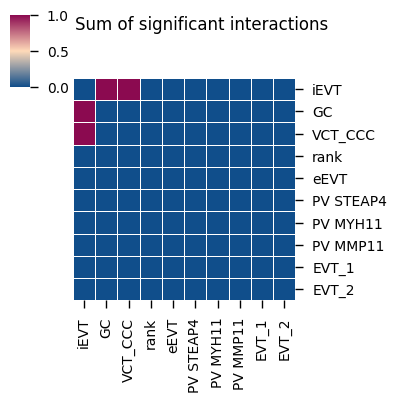

In [16]:
kpy.plot_cpdb_heatmap(pvals = cpdb_results['significant_means'],
                      degs_analysis=True,
                      figsize=(4, 4),
                      title="Sum of significant interactions")

### Detailed plots

Let's see what are the interactions changing in the glands niche in three timepoints: Proliferative, SecretoryEarly and SecretoryMid

We will do so with Dotplots to visualise the average expression of the interacting molecules (colour of dots) and at the same time its relevance (red stroke - if the interaction contains a differentially expressed gene from the DEG file).

In [17]:
kpy.plot_cpdb(
    adata = adata,
    cell_type1 = "PV MMP11|PV MYH11|PV STEAP4",
    cell_type2 = "VCT_CCC|EVT_1|EVT_2|GC|eEVT|iEVT", 
    means = cpdb_results['significant_means'],
    pvals = cpdb_results['pvalues'],
    celltype_key = "cell_type",
#     genes = ["JAG1"],
    figsize = (8,20),
    title = "Interactions between PV \nand trophoblast in the maternal endometrium",
    max_size = 5,
    highlight_size = 0.75,
    degs_analysis = False,
    standard_scale = False,
    interaction_scores = cpdb_results['interaction_scores'],
    scale_alpha_by_interaction_scores=True,
)

KeyError: 'cell_type'

In [ ]:
from plotnine import facet_wrap

p = kpy.plot_cpdb(
    adata = adata,
    cell_type1 = "PV MMP11|PV MYH11|PV STEAP4",
    cell_type2 = "VCT_CCC|EVT_1|EVT_2|GC|eEVT|iEVT", 
    means = cpdb_results['significant_means'],
    pvals = cpdb_results['pvalues'],
    celltype_key = "cell_type",
#     genes = ["JAG1"],
    figsize = (15,25),
    title = "Interactions between PV \nand trophoblast in the maternal endometrium",
    max_size = 5,
    highlight_size = 0.75,
    degs_analysis = False,
    standard_scale = False,
    interaction_scores = cpdb_results['interaction_scores'],
    scale_alpha_by_interaction_scores=True,
)

p + facet_wrap("~ classification", ncol = 2, scales='free_y')